<a href="https://colab.research.google.com/github/jjangmo91/Cervus-nippon_Anmado-Is./blob/main/Cervus-nippon_Anmado-Is.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine을 활용한 안마도 식생 분석
Google Earth Engine과 Colab을 이용하여, 안마도의 유기된 대만꽃사슴의 증가와 그로 인한 피해를 조사하는 프로젝트입니다.
안마도에 사슴이 들어온 1985년부터, 30여년간의 피해 상황을 시계열 분석을 통하여 식생 변화를 알아보겠습니다.
<br><br>
분석 단계는 다음과 같습니다:
* 분석에 필요한 API와 라이브러리를 호출합니다.
* 분석을 위한 관심 영역(AOI)을 설정합니다.
* 30년여간의 위성 데이터(Landsat)를 수집합니다.
* Landsat 데이터를 활용하여 구름 없는 대기 보정 이미지를 생산합니다.
* NDVI 계산을 수행하고, 다년도 이미지에 대해 탐색적 데이터 분석(EDA)과 전처리를 진행합니다.
* NDVI 변화에 대해 시계열 분석을 진행합니다.

## 1. Google Earth Engine 초기화 및 필요 라이브러리 로드


In [185]:
# Earth Engine Python API 모듈 및 라이브러리 호출
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal
import requests
import json
import geopandas as gpd
import os
import shutil
import psutil
from google.colab import drive
import zipfile

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-jjangmo91')

## 2. 관심 영역(AOI) 설정
안마도의 위치를 관심 영역(AOI: Area of Interest)으로 설정합니다.

In [186]:
# 안마도의 위치를 기반으로 관심 지역을 설정합니다.
anmado_location = ee.Geometry.Point([126.028111, 35.344031])
aoi = anmado_location.buffer(5000).bounds()  # 버퍼와 경계 설정

# 연구지역 경계를 지도에 추가
outline = ee.Image().byte().paint(featureCollection=aoi, color=1, width=3)

# 지도 객체 생성
Map = geemap.Map(center=[35.344031, 126.028111], zoom=12)
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(aoi, 7)
Map

Map(center=[35.34403541471917, 126.02820130275431], controls=(WidgetControl(options=['position', 'transparent_…

## 3. 위성 이미지 수집
위성 이미지 데이터를 시계열로 수집하여 분석합니다. 여기서는 Landsat5(TM), Landsat8(OLI/TIRS) 이미지를 사용합니다.
<br>
* Landsat5는 미국 지질 조사국(USGS)과 나사(NASA)가 공동으로 운영하는 Landsat 위성 프로그램의 일부로, 1984년 3월에 발사되어 2013년까지 약 29년 동안 운영되었습니다. 전 세계를 대상으로 16일마다 재방문하는 광역(wide-swath), 중간 해상도(medium-resolution) 다중 스펙트럼(multispectral) 이미징 임무를 수행했습니다. 이 위성의 Thematic Mapper(TM) 센서는 7개의 분광 밴드를 포함하며, 가시광선 및 근적외선(NIR)을 30미터, 열적외선을 120미터(재조정으로 30미터) 공간 해상도로 측정합니다. 이를 통해 식생, 토양, 수체의 상태 및 변화를 평가하는 데 적합한 데이터를 제공합니다.

* Landsat8은 2013년에 발사되었으며, Landsat5와 마찬가지로 16일마다 재방문하는
광역(wide-swath), 중간 해상도(medium-resolution), 다중 스펙트럼 이미징 임무(multispectral imaging mission)입니다. Landsat8의 두 주요 센서인 Operational Land Imager(OLI)와 Thermal Infrared Sensor(TIRS)는 다양한 분광 밴드를 취급합니다. OLI는 가시광선 및 근적외선(NIR)을 30미터, 해안/에어로졸 밴드를 30미터 해상도로, TIRS는 두 개의 열적외선 밴드를 통해 100미터 해상도로 측정합니다. 이는 지표 온도, 식생, 토양, 수체의 상태 및 변화를 평가하는 데 적합한 데이터를 제공하여 농업, 산림, 도시 계획 및 환경 관리 등에 광범위하게 활용됩니다.
<br>
아래의 함수는 pixel_qa 레이어의 비트마스크를 사용하여 구름, 구름 그림자, 눈이 있는 픽셀을 식별하고 제거합니다. 이렇게 처리된 이미지는 맑은 조건의 지표면 반사율 정보만을 포함하게 되어, NDVI와 같은 지표를 계산할 때 오류의 가능성을 줄여 줍니다. 비트 마스크의 각 값은 구름은 5번, 구름 그림자는 3번, 눈은 4번 비트를 사용합니다. 마지막으로, 대기 보정된 데이터를 스케일링하기 위해 10000으로 나누어 정규화된 반사율 값을 얻습니다. 이 함수를 사용하여 Landsat 5 및 8 이미지 컬렉션에 적용하고, NDVI 계산과 같은 후속 분석을 수행할 수 있습니다.

* Pixel QA(Quality Assessment) layer는 위성 이미지의 각 픽셀에 대한 품질 정보를 담고 있는 레이어입니다. 이 레이어는 각 픽셀의 품질을 평가하는 다양한 정보를 비트로 인코딩하여 제공합니다. 이를 통해 특정 픽셀이 구름, 구름 그림자, 눈, 물 등의 상태에 있는지 여부를 판단할 수 있습니다. 각 비트는 특정 품질 상태를 나타내며, 이러한 정보를 통해 데이터 전처리 및 분석 시 불필요한 픽셀을 필터링할 수 있습니다.

* Bitmask는 픽셀의 특정 품질 상태를 나타내는 비트를 선택하고 조작하기 위해 사용됩니다. 비트마스크를 사용하여 특정 비트가 설정되었는지 확인하고, 이를 통해 해당 상태에 있는 픽셀을 필터링하거나 선택할 수 있습니다.

* Landsat 이미지 데이터는 원래의 반사율 값이 0에서 1사이의 값이디만. 하지만, 저장 및 처리의 효율성을 위해 이 값을 일정한 스케일 팩터(보통 10000)로 곱한 후 정수 형태로 저장합니다. 예를 들어, 0.1234라면, 이를 10000으로 곱하여 1234로 저장합니다. 이를 다시 원래 값으로 변환하려면, 10000으로 나눠야 합니다.

In [187]:
def maskLandsatClouds(image):
    # QA_PIXEL 레이어 선택
    qa = image.select('QA_PIXEL')

    # 비트 마스킹을 통해 구름(clouds), 구름 그림자(cloud shadows), 눈(snow) 식별
    cloud = qa.bitwiseAnd(1 << 5)
    cloudShadow = qa.bitwiseAnd(1 << 3)
    snow = qa.bitwiseAnd(1 << 4)

    # 구름, 그림자, 눈이 없는 맑은 상태의 이미지 마스크 생성
    mask = cloud.eq(0).And(cloudShadow.eq(0)).And(snow.eq(0))

    # 마스크를 적용하고, 스케일 조정을 위해 결과를 10000으로 나눔
    return image.updateMask(mask).divide(10000)

Landsat 5 TM과 Landsat 8 OLI/TIRS 위성 이미지를 선택하고 필터링하는 과정을 수행합니다. 구체적으로 1985년부터 2024년 4월 28일까지의 기간 동안 촬영된 이미지를 대상으로 안마도 지역에 해당하는 이미지를 필터링합니다. 또한, 'pixel_qa' 레이어를 사용하여 구름과 그림자를 제거하여 맑은 상태의 이미지만을 추출하는 과정을 포함합니다. -> Collection1 서비스 종료, Collection2로 교체

In [188]:
# Landsat 5 TM 이미지 선택 및 필터링 (Collection 2 데이터 세트 사용)
landsat5_images = (
    ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    .filterDate("1985-01-01", "2012-05-05")  # Landsat 5 운영 기간
    .filterBounds(aoi)
    .map(maskLandsatClouds)  # 구름 및 그림자 마스킹 함수 적용
)

# Landsat 8 OLI/TIRS 이미지 선택 및 필터링 (Collection 2 데이터 세트 사용)
landsat8_images = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate("2013-04-11", "2024-01-31")  # Landsat 8 운영 기간
    .filterBounds(aoi)
    .map(maskLandsatClouds)  # 구름 및 그림자 마스킹 함수 적용
)

# 각 이미지 컬렉션의 이미지 개수 확인
image_count_l5 = landsat5_images.size()
image_count_l8 = landsat8_images.size()

# 이미지 개수 출력
print("Landsat 5 image count:", image_count_l5.getInfo())
print("Landsat 8 image count:", image_count_l8.getInfo())

Landsat 5 image count: 781
Landsat 8 image count: 376


# 4. NDVI 계산 및 시계열 데이터 전처리

Landsat 5와 Landsat 8의 NDVI 계산 시, 밴드 번호가 다릅니다. 따라서 NDVI 계산을 위한 함수를 두 가지로 나누어 정의합니다.

In [189]:
# NDVI 계산 함수 정의
def calculate_ndvi_landsat5(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')  # B4: NIR, B3: RED
    return image.addBands(ndvi)

def calculate_ndvi_landsat8(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')  # B5: NIR, B4: RED
    return image.addBands(ndvi)

이제 각 Landsat 이미지 컬렉션에 대해 NDVI를 계산한 후, 이들을 병합합니다.

In [190]:
# NDVI 계산
landsat5_ndvi = landsat5_images.map(calculate_ndvi_landsat5)
landsat8_ndvi = landsat8_images.map(calculate_ndvi_landsat8)

# 두 컬렉션을 병합
all_ndvi = landsat5_ndvi.merge(landsat8_ndvi)

관심 지역(AOI)에서 각 날짜별로 평균(중앙값) NDVI 값을 계산하여 시계열 데이터로 변환합니다.

In [232]:
import re

# 이미지 ID에서 날짜 추출하는 함수 (서버 측에서 실행)
def extract_date_from_id(image):
    # 이미지의 ID를 가져옴
    img_id = image.get('system:index')

    # GEE의 ee.String과 정규 표현식을 사용해 서버 측에서 날짜 추출
    date_str = ee.String(img_id).slice(-8)

    # 날짜 문자열을 'YYYY-MM-DD' 형식으로 변환
    formatted_date = ee.Date.parse('yyyyMMdd', date_str).format('YYYY-MM-dd')

    return formatted_date

# AOI에 대한 NDVI 시계열 추출 (AOI는 함수 내에서 처리)
def calculate_ndvi_time_series(img, aoi):
    # AOI에 대한 NDVI 중앙값 계산
    median_ndvi = img.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=aoi,
        scale=30
    )

    # 이미지 ID에서 날짜 추출
    date = extract_date_from_id(img)

    # 결과를 이미지의 속성으로 설정
    return img.set('NDVI', median_ndvi.get('NDVI')).set('date', date)

# 이미지 컬렉션에서 각 이미지에 대해 NDVI 시계열 계산
ndvi_timeseries = all_ndvi.map(lambda img: calculate_ndvi_time_series(img, aoi))

# 결과를 리스트로 변환
ndvi_list = ndvi_timeseries.reduceColumns(ee.Reducer.toList(2), ['date', 'NDVI']).get('list').getInfo()

          date      NDVI
0   1985-01-22 -0.057849
295 1985-01-22 -0.058442
1   1985-02-07 -0.082804
296 1985-02-07 -0.079401
2   1985-06-15 -0.021727


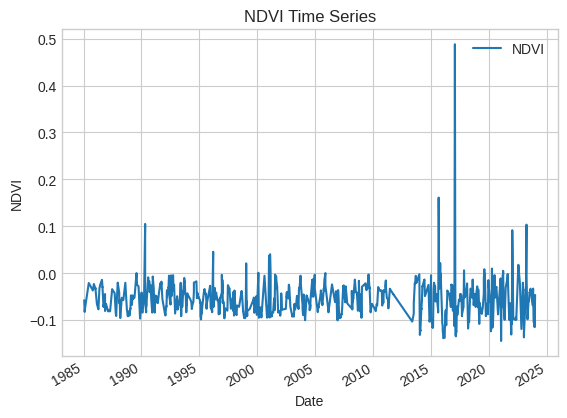

In [220]:
# NDVI 데이터프레임 생성 및 시각화
if len(ndvi_list) > 0:
    dates, ndvi_values = zip(*ndvi_list)
    df = pd.DataFrame({'date': pd.to_datetime(dates), 'NDVI': ndvi_values})

    # 날짜별로 정렬
    df = df.sort_values(by='date')

    # NDVI 시계열 데이터 출력
    print(df.head())

    # NDVI 시계열 데이터 시각화
    df.plot(x='date', y='NDVI', title='NDVI Time Series', xlabel='Date', ylabel='NDVI')
    plt.show()
else:
    print("No valid NDVI data found.")

날짜별로 두 개의 NDVI 값이 생성된 이유는 같은 날짜에 다른 밴드영역대의 정보가 있기 때문입니다. 여기서 밴드란? ~입니다. 그렇기에 하나의 값을 남기고 제거하여 사용하던가, 평균 값을 계산하는 방법이 있는데 여기선 평균을 계산하겠습니다.

In [221]:
# 날짜별로 중복된 값이 있을 경우 평균값으로 계산
df_m = df.groupby('date', as_index=False).mean()

# NDVI 시계열 데이터 출력 (처리 후)
print(df_m.head())

        date      NDVI
0 1985-01-22 -0.058146
1 1985-02-07 -0.081102
2 1985-06-15 -0.021415
3 1985-10-21 -0.037073
4 1985-11-22 -0.023195


# 5. EDA(Exploratory Data Analysis)
시계열 분석을 진행하기 전에, 데이터를 이해하고 분석하기 위한 몇 가지 사전 단계가 필요합니다. 먼저 데이터의 기초 통계량을 확인하고, 결측치나 이상치를 탐색하여 데이터의 품질을 평가하겠습니다. 그 후, NDVI 시계열 데이터를 분석하여 변화 추세와 계절성을 파악하겠습니다.

In [222]:
# 기초 통계량 확인
statistics = df_m.describe()
print("기초 통계량:\n", statistics)

기초 통계량:
                                 date        NDVI
count                            472  472.000000
mean   2004-12-05 19:07:07.118644096   -0.055624
min              1985-01-22 00:00:00   -0.144695
25%              1994-09-08 00:00:00   -0.080517
50%              2004-02-04 00:00:00   -0.056811
75%              2015-12-15 00:00:00   -0.033216
max              2023-12-17 00:00:00    0.488214
std                              NaN    0.040942


결측치 및 이상치 탐색
데이터에 결측치나 이상치가 존재하는지 확인하는 것이 중요합니다.

결측치:
 date    0
NDVI    0
dtype: int64


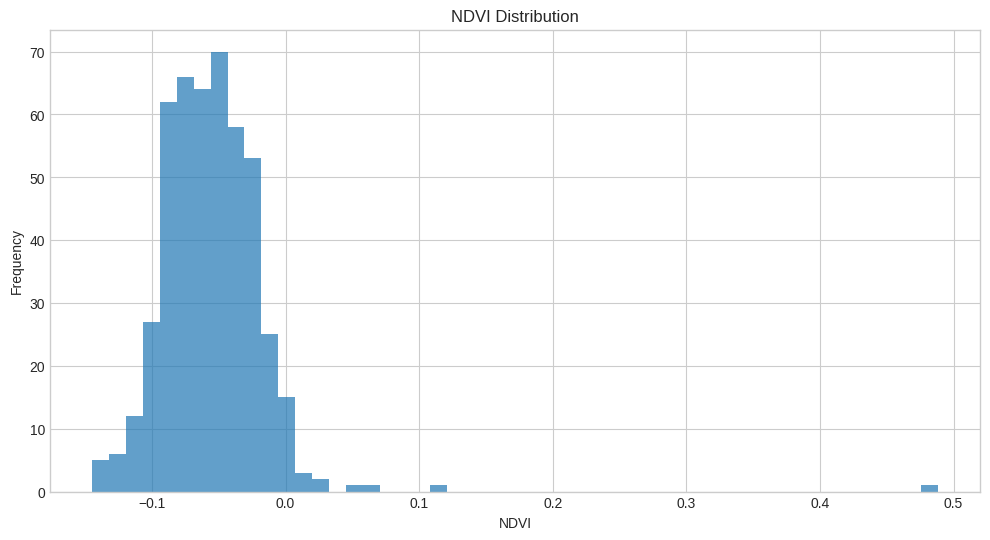

In [223]:
# 결측치 확인
missing_values = df_m.isnull().sum()
print("결측치:\n", missing_values)

# NDVI 값의 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(df_m['NDVI'], bins=50, alpha=0.7)
plt.title('NDVI Distribution')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

시계열 분석의 핵심은 데이터의 추세와 계절성을 파악하는 것입니다. 이를 위해 데이터의 이동 평균과 계절성을 시각화하고, 더 나아가 계절 분해를 통해 추세, 계절성, 불규칙성을 분리할 수 있습니다.

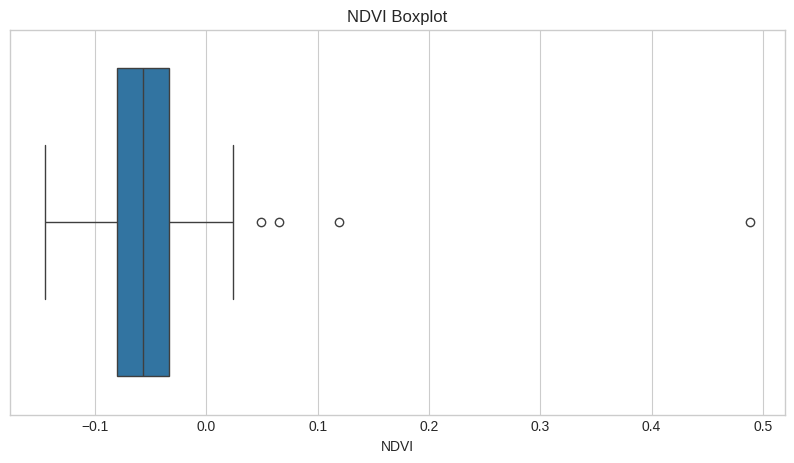

In [224]:
# NDVI 값의 박스플롯 시각화 (이상치 탐색)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_m['NDVI'])
plt.title('NDVI Boxplot')
plt.xlabel('NDVI')
plt.show()

월별 및 계절별 데이터 변화를 살펴보겠습니다.

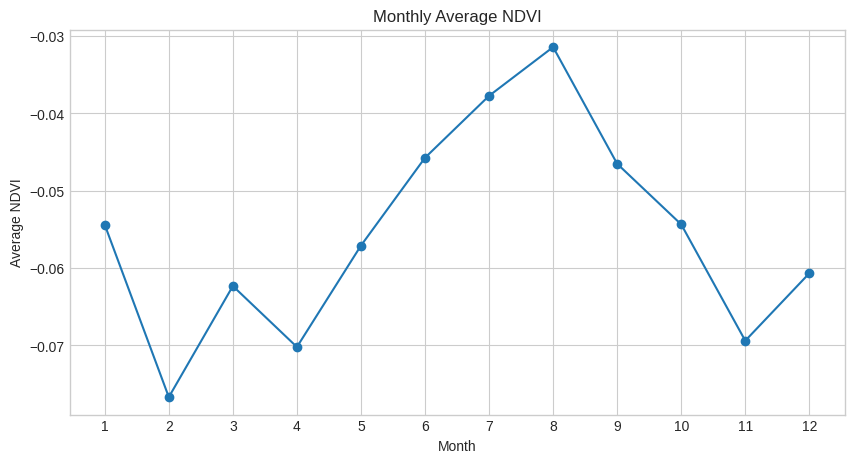

In [225]:
# 월을 추출하여 새로운 열 생성
df_m['month'] = df_m['date'].dt.month

# 월별 평균 NDVI 계산
monthly_avg_ndvi = df_m.groupby('month')['NDVI'].mean().reset_index()

# 월별 NDVI 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_ndvi['month'], monthly_avg_ndvi['NDVI'], marker='o')
plt.title('Monthly Average NDVI')
plt.xlabel('Month')
plt.ylabel('Average NDVI')
plt.xticks(range(1, 13))  # 1월부터 12월까지
plt.grid(True)
plt.show()

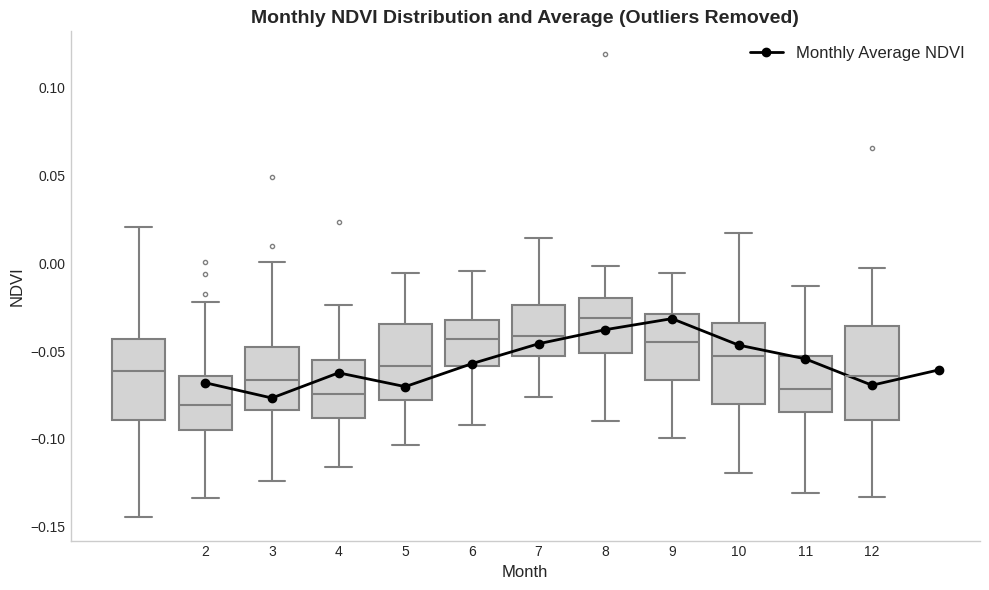

In [226]:
plt.style.use('seaborn-whitegrid')

# NDVI 값이 0.4 이상인 이상치 제거
df_m_cleaned = df_m[df_m['NDVI'] < 0.4]

# 월별로 다시 그룹화
df_m_cleaned['month'] = df_m_cleaned['date'].dt.month
monthly_avg_ndvi_cleaned = df_m_cleaned.groupby('month')['NDVI'].mean().reset_index()

# 고급지게 시각화 (박스플롯)
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='NDVI', data=df_m_cleaned, color='lightgrey', fliersize=3, linewidth=1.5)
plt.plot(monthly_avg_ndvi_cleaned['month'], monthly_avg_ndvi_cleaned['NDVI'], color='black', marker='o', linestyle='-', label='Monthly Average NDVI', linewidth=2)

# 그래프 타이틀 및 축 레이블 설정
plt.title('Monthly NDVI Distribution and Average (Outliers Removed)', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('NDVI', fontsize=12)

# X축 레이블 조정
plt.xticks(range(1, 13), fontsize=10)

# Y축 레이블 조정
plt.yticks(fontsize=10)

# 레전드 조정
plt.legend(fontsize=12, frameon=False)

# 스타일 조정
plt.grid(False)  # 그리드 최소화
sns.despine()  # 박스라인 제거

# 그래프 표시
plt.tight_layout()
plt.show()

각 월별로 여러 해 동안 NDVI 변화를 살펴보겠습니다.

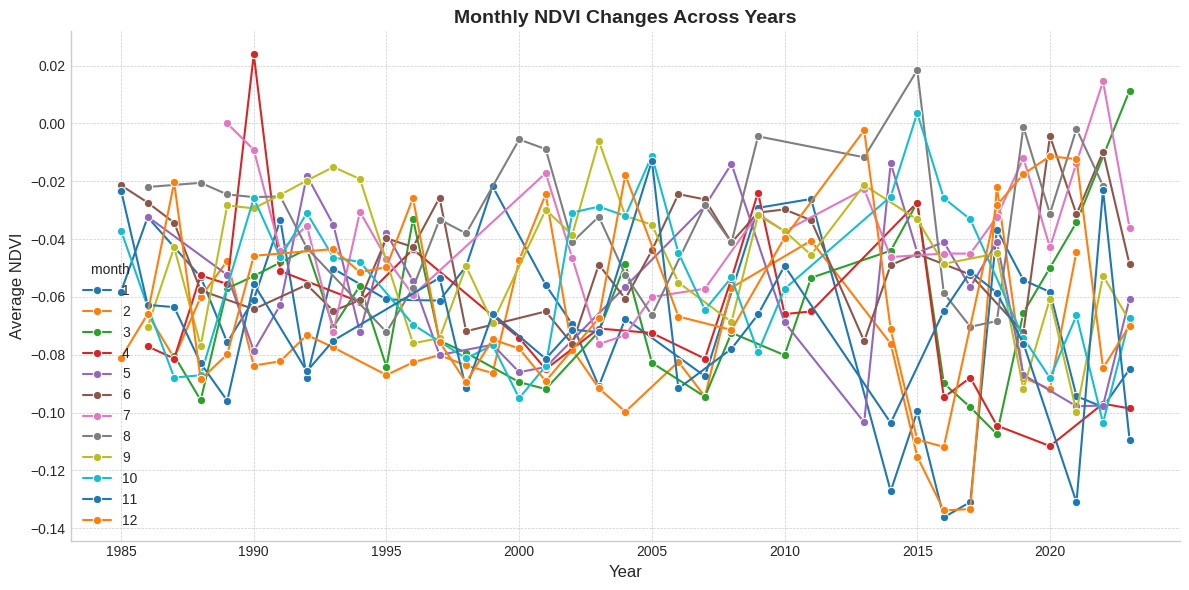

In [227]:
# 연도와 월을 추출하여 새로운 열 생성
df_m_cleaned['year'] = df_m_cleaned['date'].dt.year
df_m_cleaned['month'] = df_m_cleaned['date'].dt.month

# 월별 연도별 평균 NDVI 계산
month_year_avg_ndvi = df_m_cleaned.groupby(['year', 'month'])['NDVI'].mean().reset_index()

# 전체적인 연도별 월별 평균 NDVI 변화 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='NDVI', hue='month', data=month_year_avg_ndvi, palette='tab10', marker='o')

# 그래프 타이틀 및 축 레이블 설정
plt.title('Monthly NDVI Changes Across Years', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average NDVI', fontsize=12)

# 스타일 조정
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()  # 박스라인 제거

# 그래프 표시
plt.tight_layout()
plt.show()

계절별로 살펴봅니다.

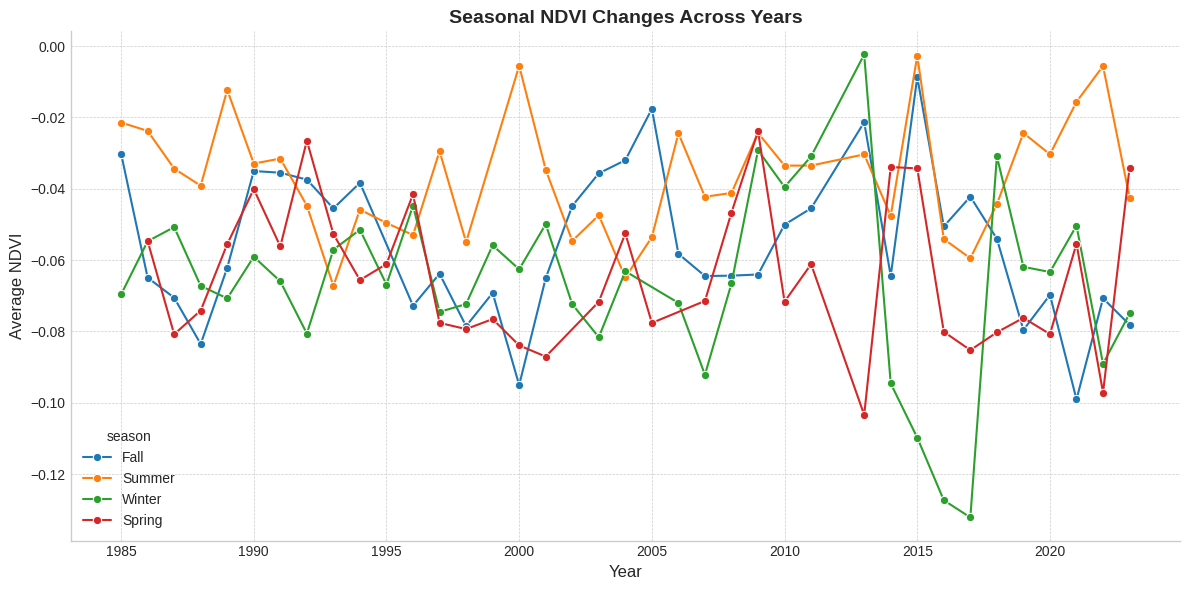

In [228]:
# 연도와 월을 추출하여 새로운 열 생성
df_m_cleaned['year'] = df_m_cleaned['date'].dt.year
df_m_cleaned['month'] = df_m_cleaned['date'].dt.month

# 계절 정보 추가
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_m_cleaned['season'] = df_m_cleaned['month'].apply(get_season)

# 계절별 연도별 평균 NDVI 계산
season_year_avg_ndvi = df_m_cleaned.groupby(['year', 'season'])['NDVI'].mean().reset_index()

# 전체적인 연도별 계절별 평균 NDVI 변화 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='NDVI', hue='season', data=season_year_avg_ndvi, palette='tab10', marker='o')

# 그래프 타이틀 및 축 레이블 설정
plt.title('Seasonal NDVI Changes Across Years', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average NDVI', fontsize=12)

# 스타일 조정
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()  # 박스라인 제거

# 그래프 표시
plt.tight_layout()
plt.show()

# 딱봐도 안되기 때문에... 새로운 AOI를 추가하여 분석합니다.
1. 먼저 안마도 임상도를 가져와서 나눠서 보고
2. 송이도 비교도 해보겠습니다.

In [233]:
# GitHub의 Raw 파일 URL 설정
url_anmado = 'https://github.com/jjangmo91/Cervus-nippon_Anmado-Is./raw/main/anmado.geojson'
url_songido = 'https://github.com/jjangmo91/Cervus-nippon_Anmado-Is./raw/main/songido.geojson'

# 파일 다운로드 및 JSON으로 변환
response_anmado = requests.get(url_anmado)
response_songido = requests.get(url_songido)
geojson_data_anmado = response_anmado.json()
geojson_data_songido = response_songido.json()

# GeoJSON 데이터를 ee.FeatureCollection으로 변환
aoi_anmado_FRTP = ee.FeatureCollection(geojson_data_anmado)
aoi_songido_FRTP = ee.FeatureCollection(geojson_data_songido)

# Landsat 5 TM 이미지 수집 및 필터링 (안마도)
landsat5_images_anmado_FRTP = (
    ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    .filterDate("1985-01-01", "2012-05-05")
    .filterBounds(aoi_anmado_FRTP)
    .map(maskLandsatClouds)
)

# Landsat 8 OLI/TIRS 이미지 수집 및 필터링 (안마도)
landsat8_images_anmado_FRTP = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate("2013-04-11", "2024-01-31")
    .filterBounds(aoi_anmado_FRTP)
    .map(maskLandsatClouds)
)

# Landsat 5 TM 이미지 수집 및 필터링 (송이도)
landsat5_images_songido_FRTP = (
    ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    .filterDate("1985-01-01", "2012-05-05")
    .filterBounds(aoi_songido_FRTP)
    .map(maskLandsatClouds)
)

# Landsat 8 OLI/TIRS 이미지 수집 및 필터링 (송이도)
landsat8_images_songido_FRTP = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate("2013-04-11", "2024-01-31")
    .filterBounds(aoi_songido_FRTP)
    .map(maskLandsatClouds)
)

# NDVI 계산 및 병합 (안마도)
landsat5_ndvi_anmado_FRTP = landsat5_images_anmado_FRTP.map(calculate_ndvi_landsat5)
landsat8_ndvi_anmado_FRTP = landsat8_images_anmado_FRTP.map(calculate_ndvi_landsat8)
all_ndvi_anmado_FRTP = landsat5_ndvi_anmado_FRTP.merge(landsat8_ndvi_anmado_FRTP)

# NDVI 계산 및 병합 (송이도)
landsat5_ndvi_songido_FRTP = landsat5_images_songido_FRTP.map(calculate_ndvi_landsat5)
landsat8_ndvi_songido_FRTP = landsat8_images_songido_FRTP.map(calculate_ndvi_landsat8)
all_ndvi_songido_FRTP = landsat5_ndvi_songido_FRTP.merge(landsat8_ndvi_songido_FRTP)

In [234]:
# AOI에 대한 NDVI 시계열 추출 (AOI는 함수 내에서 처리)
def calculate_ndvi_time_series(img, aoi):
    # AOI에 대한 NDVI 중앙값 계산
    median_ndvi = img.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=aoi.geometry(),  # AOI를 FeatureCollection으로 처리할 때 geometry() 사용
        scale=30
    )

    # 이미지 ID에서 날짜 추출
    date = extract_date_from_id(img)

    # 결과를 이미지의 속성으로 설정
    return img.set('NDVI', median_ndvi.get('NDVI')).set('date', date)

# 안마도 산림 지역에 대한 NDVI 시계열 계산
ndvi_timeseries_anmado_forest = all_ndvi_anmado_FRTP.map(lambda img: calculate_ndvi_time_series(img, aoi_forest_anmado))

# 송이도 산림 지역에 대한 NDVI 시계열 계산
ndvi_timeseries_songido_forest = all_ndvi_songido_FRTP.map(lambda img: calculate_ndvi_time_series(img, aoi_forest_songido))

# 결과를 리스트로 변환
ndvi_list_anmado_forest = ndvi_timeseries_anmado_forest.reduceColumns(ee.Reducer.toList(2), ['date', 'NDVI']).get('list').getInfo()
ndvi_list_songido_forest = ndvi_timeseries_songido_forest.reduceColumns(ee.Reducer.toList(2), ['date', 'NDVI']).get('list').getInfo()

# NDVI 데이터프레임 생성 및 시각화
df_anmado_forest = pd.DataFrame({'date': pd.to_datetime([x[0] for x in ndvi_list_anmado_forest]), 'NDVI': [x[1] for x in ndvi_list_anmado_forest]})
df_songido_forest = pd.DataFrame({'date': pd.to_datetime([x[0] for x in ndvi_list_songido_forest]), 'NDVI': [x[1] for x in ndvi_list_songido_forest]})

# 날짜별로 정렬
df_anmado_forest = df_anmado_forest.sort_values(by='date')
df_songido_forest = df_songido_forest.sort_values(by='date')

# 안마도와 송이도에 대한 NDVI 시계열 데이터 출력
print("안마도 산림 지역 NDVI 시계열:")
print(df_anmado_forest.head())
print("송이도 산림 지역 NDVI 시계열:")
print(df_songido_forest.head())

# 두 지역의 NDVI 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_anmado_forest['date'], df_anmado_forest['NDVI'], label='Anmado Forest NDVI')
plt.plot(df_songido_forest['date'], df_songido_forest['NDVI'], label='Songido Forest NDVI')
plt.title('NDVI Time Series Comparison: Anmado vs Songido (Forest Areas)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'aoi_forest_anmado' is not defined